# Word Embedding avec l'utilisation de tensorflow keras

In [209]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import csv
import nltk
import io

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
from sklearn.model_selection import train_test_split

from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter

from gensim.models import Word2Vec
from gensim.models import KeyedVectors

from nltk.cluster import KMeansClusterer
from nltk.tokenize import word_tokenize

from sklearn import cluster
from sklearn import metrics

from tensorflow.keras.preprocessing.text import one_hot
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

## Création d'un réseau de neurones à partir de vecteurs de mots

In [210]:
vocab_size = 1000
embedding_dim = 16
max_length = 120
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"

### Récupérer nos données

In [211]:
data = pd.read_csv("my_csv_clean.csv",sep = ',') #we got that csv after running the Text Preprocessing file
data.columns = ['tweet', 'class']
    
X = data['tweet']
y = data['class'] 

categories = ["NotSexist", "Sexist"]

X_train, X_test, y_train , y_test = train_test_split(X , y ,test_size=0.3)

X = list(X)
y = [categories[i] for i in y]
X_train = list(X_train)
X_test = list(X_test)
y_train = [categories[i] for i in y_train]
y_test = [categories[i] for i in y_test]
print(y_train)

['NotSexist', 'NotSexist', 'Sexist', 'Sexist', 'NotSexist', 'NotSexist', 'Sexist', 'NotSexist', 'NotSexist', 'Sexist', 'Sexist', 'NotSexist', 'NotSexist', 'NotSexist', 'NotSexist', 'Sexist', 'NotSexist', 'Sexist', 'NotSexist', 'NotSexist', 'NotSexist', 'Sexist', 'NotSexist', 'NotSexist', 'NotSexist', 'NotSexist', 'Sexist', 'Sexist', 'Sexist', 'Sexist', 'Sexist', 'NotSexist', 'NotSexist', 'NotSexist', 'Sexist', 'NotSexist', 'NotSexist', 'NotSexist', 'NotSexist', 'NotSexist', 'NotSexist', 'Sexist', 'Sexist', 'Sexist', 'NotSexist', 'NotSexist', 'Sexist', 'Sexist', 'NotSexist', 'Sexist', 'Sexist', 'Sexist', 'Sexist', 'NotSexist', 'NotSexist', 'NotSexist', 'NotSexist', 'NotSexist', 'NotSexist', 'NotSexist', 'NotSexist', 'Sexist', 'NotSexist', 'Sexist', 'NotSexist', 'NotSexist', 'Sexist', 'NotSexist', 'NotSexist', 'Sexist', 'NotSexist', 'NotSexist', 'Sexist', 'NotSexist', 'Sexist', 'NotSexist', 'Sexist', 'NotSexist', 'Sexist', 'NotSexist', 'NotSexist', 'NotSexist', 'Sexist', 'Sexist', 'NotSe

### Tokeniser les phrases

In [212]:
tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(X_train)

In [213]:
word_index = tokenizer.word_index
total_words = len(word_index)+1 # le +1 est pour le OOV
print("Total_words = ", total_words)
print("Word index : \n", word_index)

Total_words =  8740
Word index : 
 {'<OOV>': 1, 'balancetonporc': 2, 'femm': 3, 'pas': 4, 'est': 5, 'il': 6, 'sexism': 7, 'ne': 8, 'moiauss': 9, 'ca': 10, 'plus': 11, 'tout': 12, 'fait': 13, 'contr': 14, 'metoo': 15, 'elle': 16, 'homm': 17, 'comm': 18, 'un': 19, 'vi': 20, 'si': 21, 'sexist': 22, 'viol': 23, 'fair': 24, 'merkel': 25, 'angel': 26, 'mem': 27, 'bien': 28, 'quand': 29, 'ete': 30, 'apre': 31, 'parl': 32, 'ensemblecontrelesex': 33, 'femin': 34, 'iron': 35, 'y': 36, 'harcel': 37, 'ai': 38, 'autr': 39, 'dit': 40, 'mond': 41, 'etre': 42, 'auss': 43, 'franc': 44, 'sexuel': 45, 'bon': 46, 'mouv': 47, 'bleu': 48, 'travail': 49, 'va': 50, 'non': 51, 'fill': 52, 'journe': 53, 'tre': 54, 'tous': 55, 'quil': 56, 'macron': 57, 'faut': 58, 'pourquoi': 59, 'royal': 60, 'alor': 61, 'vrai': 62, 'enceint': 63, 'victim': 64, 'egalit': 65, 'merc': 66, 'nest': 67, 'etmainten': 68, 'rien': 69, 'part': 70, 'segolen': 71, 'dir': 72, 'aujourhui': 73, 'quel': 74, 'match': 75, 'accus': 76, 'toujour':

In [214]:
train_sequences = tokenizer.texts_to_sequences(X_train)
train_filled = pad_sequences(train_sequences, padding=padding_type, maxlen=max_length)

validation_sequences = tokenizer.texts_to_sequences(X_test)
validation_filled = pad_sequences(validation_sequences, padding=padding_type, maxlen=max_length)

### Tokeniser les catégories

In [215]:
label_tokenizer = Tokenizer()
label_tokenizer.fit_on_texts(y)

training_label_seq = np.array(label_tokenizer.texts_to_sequences(y_train))
validation_label_seq = np.array(label_tokenizer.texts_to_sequences(y_test))

### Création du modèle

In [216]:
modele = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dense(6, activation='softmax')
])
modele.compile(loss='sparse_categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
modele.summary()

Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_21 (Embedding)    (None, 120, 16)           16000     
                                                                 
 global_average_pooling1d_21  (None, 16)               0         
  (GlobalAveragePooling1D)                                       
                                                                 
 dense_42 (Dense)            (None, 24)                408       
                                                                 
 dense_43 (Dense)            (None, 6)                 150       
                                                                 
Total params: 16,558
Trainable params: 16,558
Non-trainable params: 0
_________________________________________________________________


In [217]:
num_epochs = 30
history = modele.fit(train_filled, training_label_seq, epochs=num_epochs, 
                    validation_data=(validation_filled, validation_label_seq), 
                    verbose=2)

Epoch 1/30
69/69 - 1s - loss: 1.5564 - accuracy: 0.6877 - val_loss: 1.2405 - val_accuracy: 0.6815 - 745ms/epoch - 11ms/step
Epoch 2/30
69/69 - 0s - loss: 0.9345 - accuracy: 0.6877 - val_loss: 0.7541 - val_accuracy: 0.6815 - 196ms/epoch - 3ms/step
Epoch 3/30
69/69 - 0s - loss: 0.6906 - accuracy: 0.6877 - val_loss: 0.6604 - val_accuracy: 0.6815 - 211ms/epoch - 3ms/step
Epoch 4/30
69/69 - 0s - loss: 0.6417 - accuracy: 0.6877 - val_loss: 0.6380 - val_accuracy: 0.6815 - 195ms/epoch - 3ms/step
Epoch 5/30
69/69 - 0s - loss: 0.6299 - accuracy: 0.6877 - val_loss: 0.6306 - val_accuracy: 0.6815 - 188ms/epoch - 3ms/step
Epoch 6/30
69/69 - 0s - loss: 0.6229 - accuracy: 0.6877 - val_loss: 0.6270 - val_accuracy: 0.6815 - 188ms/epoch - 3ms/step
Epoch 7/30
69/69 - 0s - loss: 0.6201 - accuracy: 0.6877 - val_loss: 0.6244 - val_accuracy: 0.6815 - 193ms/epoch - 3ms/step
Epoch 8/30
69/69 - 0s - loss: 0.6193 - accuracy: 0.6877 - val_loss: 0.6229 - val_accuracy: 0.6815 - 186ms/epoch - 3ms/step
Epoch 9/30
69/6

### Représentation graphique des différentes accuracy obtenues

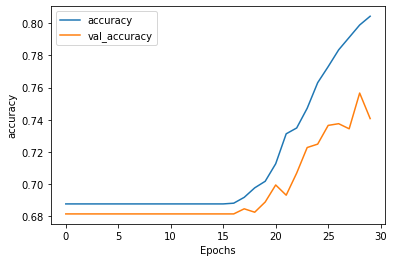

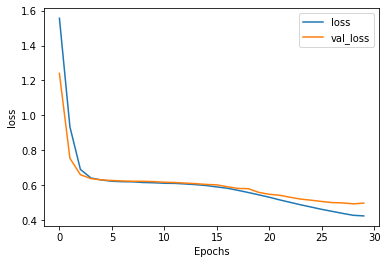

In [218]:
def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()

plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [219]:
y_pred = modele.predict(validation_filled)
predictions = np.argmax(y_pred,axis=1)

for i in range(len(predictions)):
    predictions[i] = predictions[i] - 1
    
true_labels = []
for i in y_test:
    if(i=='NotSexist'):
        true_labels.append(0)
    else:
        true_labels.append(1)
    
print("Accuracy : ", np.mean(predictions == true_labels))
print("Matrice de confusion :")
print(metrics.confusion_matrix(true_labels, predictions))
print(metrics.classification_report(true_labels, predictions,target_names=categories))

Accuracy :  0.7407407407407407
Matrice de confusion :
[[610  34]
 [211  90]]
              precision    recall  f1-score   support

   NotSexist       0.74      0.95      0.83       644
      Sexist       0.73      0.30      0.42       301

    accuracy                           0.74       945
   macro avg       0.73      0.62      0.63       945
weighted avg       0.74      0.74      0.70       945



### Pour la visualisation de nos vecteurs de mots sur https://projector.tensorflow.org/

In [220]:
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])
def decode_sentence(text):
    return ' '.join([reverse_word_index.get(i, '?') for i in text])

In [221]:
e = modele.layers[0]
weights = e.get_weights()[0]
print(weights.shape)

(1000, 16)


In [222]:
out_v = io.open('vecs.tsv', 'w', encoding='utf-8')
out_m = io.open('meta.tsv', 'w', encoding='utf-8')
for word_num in range(1, vocab_size):
    word = reverse_word_index[word_num]
    embeddings = weights[word_num]
    out_m.write(word + "\n")
    out_v.write('\t'.join([str(x) for x in embeddings]) + "\n")
out_v.close()
out_m.close()

In [223]:
#On a essayé d'ajouter des poids à certains mots, malheureusement sans succès
'''import re
stereotype_liste = []

with open('stereotype_liste.txt',encoding='utf8') as f:
    stereotype_liste = f.readlines()

weighted_words = [re.sub(r"\n",'',i) for i in stereotype_liste]

print(weighted_words)

from sklearn.feature_extraction.text import TfidfVectorizer
   
data = pd.read_csv("my_csv_clean.csv",sep = ',') #we got that csv after running the Text Preprocessing file
data.columns = ['tweet', 'class'] 

X = data['tweet']
y = data['class'] 

categories = ["NotSexist", "Sexist"]

vectorizer = TfidfVectorizer()
new_X = vectorizer.fit_transform(X)
vectorizer.get_feature_names_out()'''

'import re\nstereotype_liste = []\n\nwith open(\'stereotype_liste.txt\',encoding=\'utf8\') as f:\n    stereotype_liste = f.readlines()\n\nweighted_words = [re.sub(r"\n",\'\',i) for i in stereotype_liste]\n\nprint(weighted_words)\n\nfrom sklearn.feature_extraction.text import TfidfVectorizer\n   \ndata = pd.read_csv("my_csv_clean.csv",sep = \',\') #we got that csv after running the Text Preprocessing file\ndata.columns = [\'tweet\', \'class\'] \n\nX = data[\'tweet\']\ny = data[\'class\'] \n\ncategories = ["NotSexist", "Sexist"]\n\nvectorizer = TfidfVectorizer()\nnew_X = vectorizer.fit_transform(X)\nvectorizer.get_feature_names_out()'

## Création d'un réseau de neurone à partir de vecteur de mots avec recours à de l'oversampling

In [224]:
data = pd.read_csv("my_csv_clean.csv",sep = ',') #we got that csv after running the Text Preprocessing file
data.columns = ['tweet', 'class']

X = data['tweet']
y = data['class'] 

X_train, X_test, y_train , y_test = train_test_split(X , y ,test_size=0.3)

X = list(X)
y = [categories[i] for i in y]
X_test = list(X_test)
y_train = [categories[i] for i in y_train]
y_test = [categories[i] for i in y_test]

ros = RandomOverSampler()
X_ros_train, y_ros_train = ros.fit_resample(np.array(X_train).reshape(-1,1), y_train)# new class distribution 
X_ros_test, y_ros_test = ros.fit_resample(np.array(X_test).reshape(-1,1), y_test)# new class distribution 
X_ros_train = X_ros_train.tolist()
X_ros_test = X_ros_test.tolist()

tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(X_ros_train)

word_index = tokenizer.word_index
total_words = len(word_index)+1 #1 for oov word

train_sequences = tokenizer.texts_to_sequences(X_ros_train)
train_filled = pad_sequences(train_sequences, padding=padding_type, maxlen=max_length)

validation_sequences = tokenizer.texts_to_sequences(X_ros_test)
validation_filled = pad_sequences(validation_sequences, padding=padding_type, maxlen=max_length)

label_tokenizer = Tokenizer()
label_tokenizer.fit_on_texts(y)

training_label_seq = np.array(label_tokenizer.texts_to_sequences(y_ros_train))
validation_label_seq = np.array(label_tokenizer.texts_to_sequences(y_ros_test))

modele = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dense(6, activation='softmax')
])
modele.compile(loss='sparse_categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
modele.summary()

Model: "sequential_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_22 (Embedding)    (None, 120, 16)           16000     
                                                                 
 global_average_pooling1d_22  (None, 16)               0         
  (GlobalAveragePooling1D)                                       
                                                                 
 dense_44 (Dense)            (None, 24)                408       
                                                                 
 dense_45 (Dense)            (None, 6)                 150       
                                                                 
Total params: 16,558
Trainable params: 16,558
Non-trainable params: 0
_________________________________________________________________


In [225]:
num_epochs = 30
history = modele.fit(train_filled, training_label_seq, epochs=num_epochs, 
                    validation_data=(validation_filled, validation_label_seq), 
                    verbose=2)

Epoch 1/30
94/94 - 1s - loss: 1.4815 - accuracy: 0.5073 - val_loss: 1.0609 - val_accuracy: 0.5000 - 757ms/epoch - 8ms/step
Epoch 2/30
94/94 - 0s - loss: 0.8268 - accuracy: 0.4967 - val_loss: 0.7276 - val_accuracy: 0.5000 - 249ms/epoch - 3ms/step
Epoch 3/30
94/94 - 0s - loss: 0.7139 - accuracy: 0.4983 - val_loss: 0.7047 - val_accuracy: 0.5000 - 281ms/epoch - 3ms/step
Epoch 4/30
94/94 - 0s - loss: 0.7013 - accuracy: 0.5144 - val_loss: 0.6993 - val_accuracy: 0.5000 - 210ms/epoch - 2ms/step
Epoch 5/30
94/94 - 0s - loss: 0.6969 - accuracy: 0.5217 - val_loss: 0.6991 - val_accuracy: 0.5000 - 214ms/epoch - 2ms/step
Epoch 6/30
94/94 - 0s - loss: 0.6957 - accuracy: 0.5047 - val_loss: 0.6963 - val_accuracy: 0.5000 - 252ms/epoch - 3ms/step
Epoch 7/30
94/94 - 0s - loss: 0.6942 - accuracy: 0.5134 - val_loss: 0.6952 - val_accuracy: 0.5000 - 240ms/epoch - 3ms/step
Epoch 8/30
94/94 - 0s - loss: 0.6930 - accuracy: 0.5538 - val_loss: 0.6958 - val_accuracy: 0.5000 - 235ms/epoch - 3ms/step
Epoch 9/30
94/94

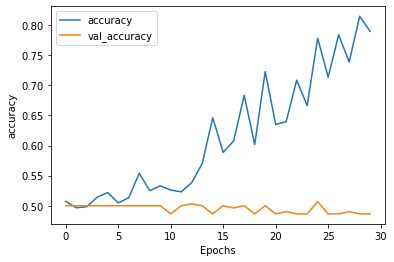

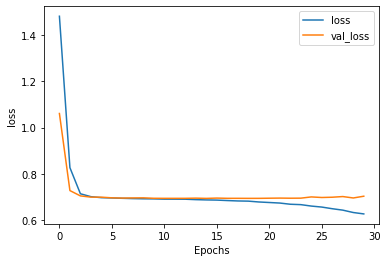

In [226]:
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [227]:
y_pred = modele.predict(validation_filled)
predictions = np.argmax(y_pred,axis=1)

for i in range(len(predictions)):
    predictions[i] = predictions[i] - 1
    
true_labels = []
for i in y_ros_test:
    if(i=='NotSexist'):
        true_labels.append(0)
    else:
        true_labels.append(1)
print("Accuracy : ", np.mean(predictions == true_labels))
print("Matrice de confusion :")
print(metrics.confusion_matrix(true_labels, predictions))
print(metrics.classification_report(true_labels, predictions,target_names=categories))

Accuracy :  0.486404833836858
Matrice de confusion :
[[634  28]
 [652  10]]
              precision    recall  f1-score   support

   NotSexist       0.49      0.96      0.65       662
      Sexist       0.26      0.02      0.03       662

    accuracy                           0.49      1324
   macro avg       0.38      0.49      0.34      1324
weighted avg       0.38      0.49      0.34      1324



## Création d'un réseau de neurone à partir de vecteur de mots avec recours à de l'undersampling

In [228]:
data = pd.read_csv("my_csv_clean.csv",sep = ',') #we got that csv after running the Text Preprocessing file
data.columns = ['tweet', 'class']

X = data['tweet']
y = data['class'] 

X_train, X_test, y_train , y_test = train_test_split(X , y ,test_size=0.3)

X = list(X)
y = [categories[i] for i in y]
X_test = list(X_test)
y_train = [categories[i] for i in y_train]
y_test = [categories[i] for i in y_test]

rus = RandomUnderSampler()
X_rus_train, y_rus_train = rus.fit_resample(np.array(X_train).reshape(-1,1), y_train)# new class distribution 
X_rus_test, y_rus_test = rus.fit_resample(np.array(X_test).reshape(-1,1), y_test)# new class distribution 
X_rus_train = X_rus_train.tolist()
X_rus_test = X_rus_test.tolist()

tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(X_rus_train)

word_index = tokenizer.word_index
total_words = len(word_index)+1

train_sequences = tokenizer.texts_to_sequences(X_rus_train)
train_filled = pad_sequences(train_sequences, padding=padding_type, maxlen=max_length)

validation_sequences = tokenizer.texts_to_sequences(X_rus_test)
validation_filled = pad_sequences(validation_sequences, padding=padding_type, maxlen=max_length)

label_tokenizer = Tokenizer()
label_tokenizer.fit_on_texts(y)

training_label_seq = np.array(label_tokenizer.texts_to_sequences(y_rus_train))
validation_label_seq = np.array(label_tokenizer.texts_to_sequences(y_rus_test))

modele = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dense(6, activation='softmax')
])
modele.compile(loss='sparse_categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
modele.summary()

Model: "sequential_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_23 (Embedding)    (None, 120, 16)           16000     
                                                                 
 global_average_pooling1d_23  (None, 16)               0         
  (GlobalAveragePooling1D)                                       
                                                                 
 dense_46 (Dense)            (None, 24)                408       
                                                                 
 dense_47 (Dense)            (None, 6)                 150       
                                                                 
Total params: 16,558
Trainable params: 16,558
Non-trainable params: 0
_________________________________________________________________


In [229]:
num_epochs = 30
history = modele.fit(train_filled, training_label_seq, epochs=num_epochs, 
                    validation_data=(validation_filled, validation_label_seq), 
                    verbose=2)

Epoch 1/30
44/44 - 1s - loss: 1.6827 - accuracy: 0.5000 - val_loss: 1.5675 - val_accuracy: 0.5000 - 664ms/epoch - 15ms/step
Epoch 2/30
44/44 - 0s - loss: 1.3947 - accuracy: 0.5000 - val_loss: 1.1799 - val_accuracy: 0.5000 - 136ms/epoch - 3ms/step
Epoch 3/30
44/44 - 0s - loss: 1.0047 - accuracy: 0.5000 - val_loss: 0.8618 - val_accuracy: 0.5000 - 157ms/epoch - 4ms/step
Epoch 4/30
44/44 - 0s - loss: 0.7945 - accuracy: 0.5000 - val_loss: 0.7491 - val_accuracy: 0.5000 - 156ms/epoch - 4ms/step
Epoch 5/30
44/44 - 0s - loss: 0.7308 - accuracy: 0.5115 - val_loss: 0.7197 - val_accuracy: 0.5000 - 159ms/epoch - 4ms/step
Epoch 6/30
44/44 - 0s - loss: 0.7126 - accuracy: 0.5064 - val_loss: 0.7085 - val_accuracy: 0.5000 - 142ms/epoch - 3ms/step
Epoch 7/30
44/44 - 0s - loss: 0.7053 - accuracy: 0.5229 - val_loss: 0.7037 - val_accuracy: 0.5000 - 143ms/epoch - 3ms/step
Epoch 8/30
44/44 - 0s - loss: 0.7017 - accuracy: 0.4979 - val_loss: 0.7009 - val_accuracy: 0.5000 - 143ms/epoch - 3ms/step
Epoch 9/30
44/4

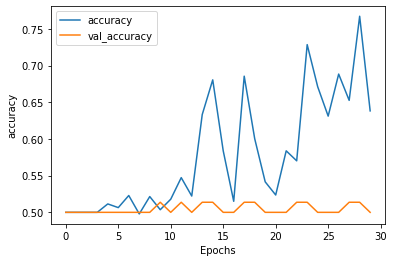

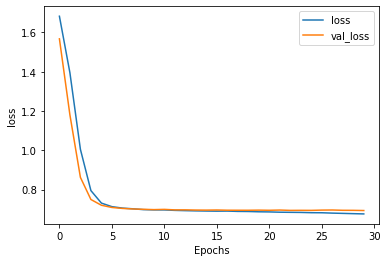

In [230]:
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [231]:
y_pred = modele.predict(validation_filled)
predictions = np.argmax(y_pred,axis=1)

for i in range(len(predictions)):
    predictions[i] = predictions[i] - 1
    
true_labels = []
for i in y_rus_test:
    if(i=='NotSexist'):
        true_labels.append(0)
    else:
        true_labels.append(1)
    
print("Accuracy : ", np.mean(predictions == true_labels))
print("Matrice de confusion :") 
print(metrics.confusion_matrix(true_labels, predictions))
print(metrics.classification_report(true_labels, predictions,target_names=categories))

Accuracy :  0.5
Matrice de confusion :
[[291   0]
 [291   0]]
              precision    recall  f1-score   support

   NotSexist       0.50      1.00      0.67       291
      Sexist       0.00      0.00      0.00       291

    accuracy                           0.50       582
   macro avg       0.25      0.50      0.33       582
weighted avg       0.25      0.50      0.33       582



C:\Users\evara\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\evara\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\evara\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Changement de paramètre du réseau initial - vocab size = 4000

In [232]:
vocab_size = 4000
embedding_dim = 16
max_length = 120
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"

In [233]:
data = pd.read_csv("my_csv_clean.csv",sep = ',') #we got that csv after running the Text Preprocessing file
data.columns = ['tweet', 'class']
    
X = data['tweet']
y = data['class'] 

categories = ["NotSexist", "Sexist"]

X_train, X_test, y_train , y_test = train_test_split(X , y ,test_size=0.3)

X = list(X)
y = [categories[i] for i in y]
X_train = list(X_train)
X_test = list(X_test)
y_train = [categories[i] for i in y_train]
y_test = [categories[i] for i in y_test]
print(y_train)

['Sexist', 'NotSexist', 'NotSexist', 'NotSexist', 'NotSexist', 'Sexist', 'NotSexist', 'NotSexist', 'NotSexist', 'NotSexist', 'NotSexist', 'NotSexist', 'NotSexist', 'Sexist', 'NotSexist', 'NotSexist', 'NotSexist', 'NotSexist', 'NotSexist', 'Sexist', 'Sexist', 'NotSexist', 'Sexist', 'Sexist', 'NotSexist', 'Sexist', 'Sexist', 'NotSexist', 'Sexist', 'NotSexist', 'NotSexist', 'NotSexist', 'NotSexist', 'NotSexist', 'NotSexist', 'NotSexist', 'NotSexist', 'Sexist', 'Sexist', 'Sexist', 'NotSexist', 'Sexist', 'NotSexist', 'NotSexist', 'NotSexist', 'NotSexist', 'NotSexist', 'NotSexist', 'NotSexist', 'NotSexist', 'NotSexist', 'NotSexist', 'NotSexist', 'NotSexist', 'NotSexist', 'NotSexist', 'NotSexist', 'Sexist', 'NotSexist', 'NotSexist', 'NotSexist', 'NotSexist', 'NotSexist', 'NotSexist', 'NotSexist', 'NotSexist', 'NotSexist', 'NotSexist', 'Sexist', 'NotSexist', 'NotSexist', 'NotSexist', 'NotSexist', 'NotSexist', 'NotSexist', 'Sexist', 'NotSexist', 'NotSexist', 'Sexist', 'NotSexist', 'Sexist', 'No

In [234]:
tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(X_train)

In [235]:
word_index = tokenizer.word_index
total_words = len(word_index)+1 # le +1 est pour le OOV
print("Total_words = ", total_words)
print("Word index : \n", word_index)

Total_words =  8629
Word index : 
 {'<OOV>': 1, 'balancetonporc': 2, 'femm': 3, 'pas': 4, 'est': 5, 'il': 6, 'sexism': 7, 'ne': 8, 'moiauss': 9, 'plus': 10, 'ca': 11, 'fait': 12, 'tout': 13, 'metoo': 14, 'contr': 15, 'vi': 16, 'elle': 17, 'comm': 18, 'homm': 19, 'sexist': 20, 'merkel': 21, 'si': 22, 'un': 23, 'angel': 24, 'fair': 25, 'viol': 26, 'mem': 27, 'bien': 28, 'apre': 29, 'y': 30, 'ensemblecontrelesex': 31, 'ete': 32, 'ai': 33, 'quand': 34, 'iron': 35, 'parl': 36, 'femin': 37, 'harcel': 38, 'sexuel': 39, 'etre': 40, 'autr': 41, 'quil': 42, 'franc': 43, 'auss': 44, 'mouv': 45, 'royal': 46, 'bleu': 47, 'segolen': 48, 'travail': 49, 'tous': 50, 'nest': 51, 'tre': 52, 'fill': 53, 'bon': 54, 'journe': 55, 'egalit': 56, 'dit': 57, 'aujourhui': 58, 'non': 59, 'va': 60, 'pourquoi': 61, 'etmainten': 62, 'rien': 63, 'merc': 64, 'enceint': 65, 'mond': 66, 'macron': 67, 'entre': 68, 'violenc': 69, 'vrai': 70, 'avoir': 71, 'victim': 72, 'dir': 73, 'an': 74, 'marleneschiapp': 75, 'droit': 76

In [236]:
train_sequences = tokenizer.texts_to_sequences(X_train)
train_filled = pad_sequences(train_sequences, padding=padding_type, maxlen=max_length)

validation_sequences = tokenizer.texts_to_sequences(X_test)
validation_filled = pad_sequences(validation_sequences, padding=padding_type, maxlen=max_length)

In [237]:
label_tokenizer = Tokenizer()
label_tokenizer.fit_on_texts(y)

training_label_seq = np.array(label_tokenizer.texts_to_sequences(y_train))
validation_label_seq = np.array(label_tokenizer.texts_to_sequences(y_test))

In [238]:
modele = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dense(6, activation='softmax')
])
modele.compile(loss='sparse_categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
modele.summary()

Model: "sequential_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_24 (Embedding)    (None, 120, 16)           64000     
                                                                 
 global_average_pooling1d_24  (None, 16)               0         
  (GlobalAveragePooling1D)                                       
                                                                 
 dense_48 (Dense)            (None, 24)                408       
                                                                 
 dense_49 (Dense)            (None, 6)                 150       
                                                                 
Total params: 64,558
Trainable params: 64,558
Non-trainable params: 0
_________________________________________________________________


In [239]:
num_epochs = 30
history = modele.fit(train_filled, training_label_seq, epochs=num_epochs, 
                    validation_data=(validation_filled, validation_label_seq), 
                    verbose=2)

Epoch 1/30
69/69 - 1s - loss: 1.5946 - accuracy: 0.6714 - val_loss: 1.3232 - val_accuracy: 0.6720 - 797ms/epoch - 12ms/step
Epoch 2/30
69/69 - 0s - loss: 0.9706 - accuracy: 0.6918 - val_loss: 0.7605 - val_accuracy: 0.6720 - 233ms/epoch - 3ms/step
Epoch 3/30
69/69 - 0s - loss: 0.6773 - accuracy: 0.6918 - val_loss: 0.6585 - val_accuracy: 0.6720 - 272ms/epoch - 4ms/step
Epoch 4/30
69/69 - 0s - loss: 0.6309 - accuracy: 0.6918 - val_loss: 0.6392 - val_accuracy: 0.6720 - 207ms/epoch - 3ms/step
Epoch 5/30
69/69 - 0s - loss: 0.6197 - accuracy: 0.6918 - val_loss: 0.6338 - val_accuracy: 0.6720 - 349ms/epoch - 5ms/step
Epoch 6/30
69/69 - 0s - loss: 0.6133 - accuracy: 0.6918 - val_loss: 0.6288 - val_accuracy: 0.6720 - 288ms/epoch - 4ms/step
Epoch 7/30
69/69 - 0s - loss: 0.6094 - accuracy: 0.6918 - val_loss: 0.6287 - val_accuracy: 0.6720 - 223ms/epoch - 3ms/step
Epoch 8/30
69/69 - 0s - loss: 0.6046 - accuracy: 0.6918 - val_loss: 0.6203 - val_accuracy: 0.6720 - 216ms/epoch - 3ms/step
Epoch 9/30
69/6

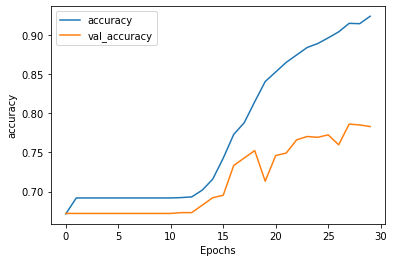

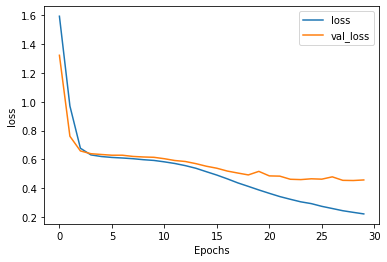

In [240]:
def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()

plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [241]:
y_pred = modele.predict(validation_filled)
predictions = np.argmax(y_pred,axis=1)

for i in range(len(predictions)):
    predictions[i] = predictions[i] - 1
    
true_labels = []
for i in y_test:
    if(i=='NotSexist'):
        true_labels.append(0)
    else:
        true_labels.append(1)
    
print("Accuracy : ", np.mean(predictions == true_labels))
print("Matrice de confusion :")
print(metrics.confusion_matrix(true_labels, predictions))
print(metrics.classification_report(true_labels, predictions,target_names=categories))

Accuracy :  0.783068783068783
Matrice de confusion :
[[581  54]
 [151 159]]
              precision    recall  f1-score   support

   NotSexist       0.79      0.91      0.85       635
      Sexist       0.75      0.51      0.61       310

    accuracy                           0.78       945
   macro avg       0.77      0.71      0.73       945
weighted avg       0.78      0.78      0.77       945



### Changement de paramètre du réseau initial - embedding_dim = 18

In [262]:
vocab_size = 1000
embedding_dim = 18
max_length = 120
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"

In [263]:
data = pd.read_csv("my_csv_clean.csv",sep = ',') #we got that csv after running the Text Preprocessing file
data.columns = ['tweet', 'class']
    
X = data['tweet']
y = data['class'] 

categories = ["NotSexist", "Sexist"]

X_train, X_test, y_train , y_test = train_test_split(X , y ,test_size=0.3)

X = list(X)
y = [categories[i] for i in y]
X_train = list(X_train)
X_test = list(X_test)
y_train = [categories[i] for i in y_train]
y_test = [categories[i] for i in y_test]
print(y_train)

['NotSexist', 'NotSexist', 'NotSexist', 'Sexist', 'NotSexist', 'NotSexist', 'NotSexist', 'NotSexist', 'NotSexist', 'NotSexist', 'NotSexist', 'NotSexist', 'Sexist', 'NotSexist', 'Sexist', 'NotSexist', 'Sexist', 'NotSexist', 'NotSexist', 'Sexist', 'NotSexist', 'NotSexist', 'NotSexist', 'NotSexist', 'NotSexist', 'NotSexist', 'NotSexist', 'NotSexist', 'NotSexist', 'Sexist', 'Sexist', 'Sexist', 'Sexist', 'NotSexist', 'NotSexist', 'NotSexist', 'NotSexist', 'Sexist', 'NotSexist', 'Sexist', 'NotSexist', 'NotSexist', 'NotSexist', 'NotSexist', 'NotSexist', 'NotSexist', 'NotSexist', 'NotSexist', 'NotSexist', 'NotSexist', 'NotSexist', 'NotSexist', 'NotSexist', 'NotSexist', 'Sexist', 'NotSexist', 'NotSexist', 'NotSexist', 'NotSexist', 'Sexist', 'Sexist', 'NotSexist', 'NotSexist', 'Sexist', 'NotSexist', 'NotSexist', 'NotSexist', 'NotSexist', 'Sexist', 'Sexist', 'NotSexist', 'Sexist', 'NotSexist', 'Sexist', 'Sexist', 'Sexist', 'Sexist', 'Sexist', 'NotSexist', 'Sexist', 'NotSexist', 'NotSexist', 'NotS

In [264]:
tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(X_train)

In [265]:
word_index = tokenizer.word_index
total_words = len(word_index)+1 # le +1 est pour le OOV
print("Total_words = ", total_words)
print("Word index : \n", word_index)

Total_words =  8620
Word index : 
 {'<OOV>': 1, 'balancetonporc': 2, 'femm': 3, 'pas': 4, 'est': 5, 'il': 6, 'sexism': 7, 'ne': 8, 'moiauss': 9, 'plus': 10, 'ca': 11, 'fait': 12, 'tout': 13, 'metoo': 14, 'elle': 15, 'contr': 16, 'vi': 17, 'homm': 18, 'comm': 19, 'un': 20, 'sexist': 21, 'merkel': 22, 'angel': 23, 'viol': 24, 'si': 25, 'fair': 26, 'quand': 27, 'femin': 28, 'bien': 29, 'apre': 30, 'mem': 31, 'parl': 32, 'ai': 33, 'ete': 34, 'ensemblecontrelesex': 35, 'y': 36, 'iron': 37, 'harcel': 38, 'etre': 39, 'auss': 40, 'franc': 41, 'sexuel': 42, 'mouv': 43, 'bleu': 44, 'quil': 45, 'royal': 46, 'tous': 47, 'fill': 48, 'autr': 49, 'nest': 50, 'segolen': 51, 'va': 52, 'non': 53, 'vrai': 54, 'journe': 55, 'macron': 56, 'dir': 57, 'etmainten': 58, 'pourquoi': 59, 'an': 60, 'may': 61, 'victim': 62, 'aujourhui': 63, 'egalit': 64, 'travail': 65, 'bon': 66, 'merc': 67, 'theres': 68, 'match': 69, 'part': 70, 'avoir': 71, 'tre': 72, 'enceint': 73, 'mond': 74, 'dit': 75, 'comment': 76, 'faut': 

In [266]:
train_sequences = tokenizer.texts_to_sequences(X_train)
train_filled = pad_sequences(train_sequences, padding=padding_type, maxlen=max_length)

validation_sequences = tokenizer.texts_to_sequences(X_test)
validation_filled = pad_sequences(validation_sequences, padding=padding_type, maxlen=max_length)

In [267]:
label_tokenizer = Tokenizer()
label_tokenizer.fit_on_texts(y)

training_label_seq = np.array(label_tokenizer.texts_to_sequences(y_train))
validation_label_seq = np.array(label_tokenizer.texts_to_sequences(y_test))

In [268]:
modele = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dense(6, activation='softmax')
])
modele.compile(loss='sparse_categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
modele.summary()

Model: "sequential_27"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_27 (Embedding)    (None, 120, 18)           18000     
                                                                 
 global_average_pooling1d_27  (None, 18)               0         
  (GlobalAveragePooling1D)                                       
                                                                 
 dense_54 (Dense)            (None, 24)                456       
                                                                 
 dense_55 (Dense)            (None, 6)                 150       
                                                                 
Total params: 18,606
Trainable params: 18,606
Non-trainable params: 0
_________________________________________________________________


In [269]:
num_epochs = 30
history = modele.fit(train_filled, training_label_seq, epochs=num_epochs, 
                    validation_data=(validation_filled, validation_label_seq), 
                    verbose=2)

Epoch 1/30
69/69 - 1s - loss: 1.5051 - accuracy: 0.6546 - val_loss: 1.1344 - val_accuracy: 0.6931 - 1s/epoch - 16ms/step
Epoch 2/30
69/69 - 0s - loss: 0.8982 - accuracy: 0.6827 - val_loss: 0.7414 - val_accuracy: 0.6931 - 209ms/epoch - 3ms/step
Epoch 3/30
69/69 - 0s - loss: 0.6975 - accuracy: 0.6827 - val_loss: 0.6499 - val_accuracy: 0.6931 - 216ms/epoch - 3ms/step
Epoch 4/30
69/69 - 0s - loss: 0.6443 - accuracy: 0.6827 - val_loss: 0.6260 - val_accuracy: 0.6931 - 207ms/epoch - 3ms/step
Epoch 5/30
69/69 - 0s - loss: 0.6305 - accuracy: 0.6827 - val_loss: 0.6191 - val_accuracy: 0.6931 - 203ms/epoch - 3ms/step
Epoch 6/30
69/69 - 0s - loss: 0.6257 - accuracy: 0.6827 - val_loss: 0.6156 - val_accuracy: 0.6931 - 190ms/epoch - 3ms/step
Epoch 7/30
69/69 - 0s - loss: 0.6218 - accuracy: 0.6827 - val_loss: 0.6133 - val_accuracy: 0.6931 - 186ms/epoch - 3ms/step
Epoch 8/30
69/69 - 0s - loss: 0.6193 - accuracy: 0.6827 - val_loss: 0.6114 - val_accuracy: 0.6931 - 195ms/epoch - 3ms/step
Epoch 9/30
69/69 -

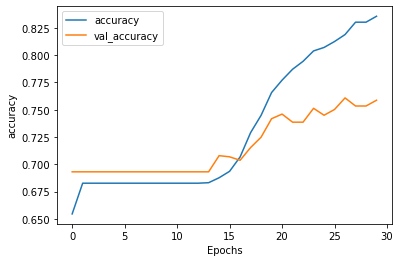

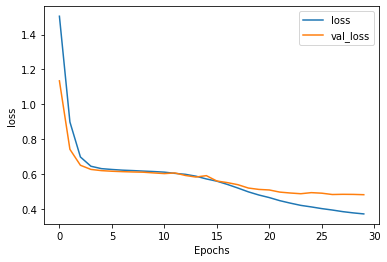

In [270]:
def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()

plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [271]:
y_pred = modele.predict(validation_filled)
predictions = np.argmax(y_pred,axis=1)

for i in range(len(predictions)):
    predictions[i] = predictions[i] - 1
    
true_labels = []
for i in y_test:
    if(i=='NotSexist'):
        true_labels.append(0)
    else:
        true_labels.append(1)
    
print("Accuracy : ", np.mean(predictions == true_labels))
print("Matrice de confusion :")
print(metrics.confusion_matrix(true_labels, predictions))
print(metrics.classification_report(true_labels, predictions,target_names=categories))

Accuracy :  0.7587301587301587
Matrice de confusion :
[[575  80]
 [148 142]]
              precision    recall  f1-score   support

   NotSexist       0.80      0.88      0.83       655
      Sexist       0.64      0.49      0.55       290

    accuracy                           0.76       945
   macro avg       0.72      0.68      0.69       945
weighted avg       0.75      0.76      0.75       945

